# Детекция спама: Подбор гиперпараметров

## Импорты / функции / константы

In [1]:
%%capture
!pip install fasttext
!pip install scikit-plot

In [11]:
from typing import List
import random
import pandas as pd
import numpy as np

import re
import fasttext
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import scikitplot as splt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.6f}'.format
plt.rcParams['figure.figsize'] = (6, 3)
%config InlineBackend.figure_format='retina'

In [3]:
def clf_report(clf_name: str, y_true: pd.Series, y_pred: np.array, y_pred_proba: np.array) -> pd.DataFrame:
    """
    Выводит репорт по качеству классификации, который включает
    метрики roc-auc, precision, recall, f1-score.
    """

    return pd.DataFrame(
      {
          'ROC AUC': roc_auc_score(y_true, y_pred_proba),
          'Precision': precision_score(y_true, y_pred),
          'Recall': recall_score(y_true, y_pred),
          'F1': f1_score(y_true, y_pred),
      },
      index=[clf_name]
    )

## Подготовка данных

### Сплит на трейн и тест

In [4]:
train_df = pd.read_csv('/kaggle/input/train-spam-preproc/train_preproc.csv')
train_df['text_type'] = train_df['text_type'].map({'spam': 1, 'ham': 0})
train_df = train_df.fillna('emptytokensequence')

In [5]:
X = train_df['text__preproc']
y = train_df['text_type']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=8)

### Векторизация

#### 1 _ TfidfVectorizer

In [7]:
tfidf_vectorizer = TfidfVectorizer(min_df=50)

In [8]:
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_train_vectorized = pd.DataFrame(
    data=X_train_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

X_test_vectorized = tfidf_vectorizer.transform(X_test)
X_test_vectorized = pd.DataFrame(
    data=X_test_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [9]:
sc = MinMaxScaler()

X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_vectorized), columns=X_train_vectorized.columns.tolist())
X_test_scaled = pd.DataFrame(sc.transform(X_test_vectorized), columns=X_test_vectorized.columns.tolist())

#### 2 _ FastText

In [12]:
train_data_ft = pd.concat([X_train.apply(lambda x: re.sub('\t', '', x)),
                           y_train.apply(lambda x: '__label__' + str(x))], axis=1)
test_data_ft = pd.concat([X_test.apply(lambda x: re.sub('\t', '', x)),
                          y_test.apply(lambda x: '__label__' + str(x))], axis=1)

train_data_ft.to_csv('train_data_ft.txt', sep='\t', header=None, index=None)
test_data_ft.to_csv('test_data_ft.txt', sep='\t', header=None, index=None)

In [13]:
ft_model = fasttext.train_supervised(
    input='train_data_ft.txt',
    minCount=5,
    minn=3,
    maxn=5,
    wordNgrams=2,
    dim=150
)

Read 0M words
Number of words:  6795
Number of labels: 2
Progress: 100.0% words/sec/thread:  121401 lr:  0.000000 avg.loss:  0.339095 ETA:   0h 0m 0s


In [14]:
X_train_ft = pd.DataFrame(
    data=X_train.apply(lambda x: ft_model.get_sentence_vector(x)).tolist(),
    columns=[f'v_{i+1}' for i in range(150)]
)
X_test_ft = pd.DataFrame(
    data=X_test.apply(lambda x: ft_model.get_sentence_vector(x)).tolist(),
    columns=[f'v_{i+1}' for i in range(150)]
)

In [15]:
sc2 = MinMaxScaler()

X_train_ftscaled = pd.DataFrame(sc2.fit_transform(X_train_ft), columns=X_train_ft.columns.tolist())
X_test_ftscaled = pd.DataFrame(sc2.transform(X_test_ft), columns=X_test_ft.columns.tolist())

## Подбор гиперпараметров

Подбор оптимальных гиперпараметров для моделей:

  - Random Forest + FastText
  - SVC + Tfidf
  - Gradient Boosting + FastText
  - Logistic Regression + FastText


### Random Forest + FastText

In [ ]:
rf2 = RandomForestClassifier(random_state=8)
rf2.fit(X_train_ft, y_train)

In [ ]:
rf_params = {
    'n_estimators': np.arange(50, 500, 50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': np.arange(2, 22, 2),
    'class_weight': ['balanced', 'balanced_subsample']
}

In [ ]:
gs_rf = RandomizedSearchCV(rf2, rf_params, n_iter=100, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gs_rf.fit(X_train_ft, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
gs_rf.best_score_, gs_rf.best_params_

In [85]:
best_rf_params = {'class_weight': 'balanced_subsample',
  'criterion': 'gini',
  'max_depth': 15,
  'max_features': 'sqrt',
  'n_estimators': 500}

In [86]:
best_rf_ft = RandomForestClassifier(**best_rf_params, random_state=8)
best_rf_ft.fit(X_train_ft, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_estimators=500, random_state=8)

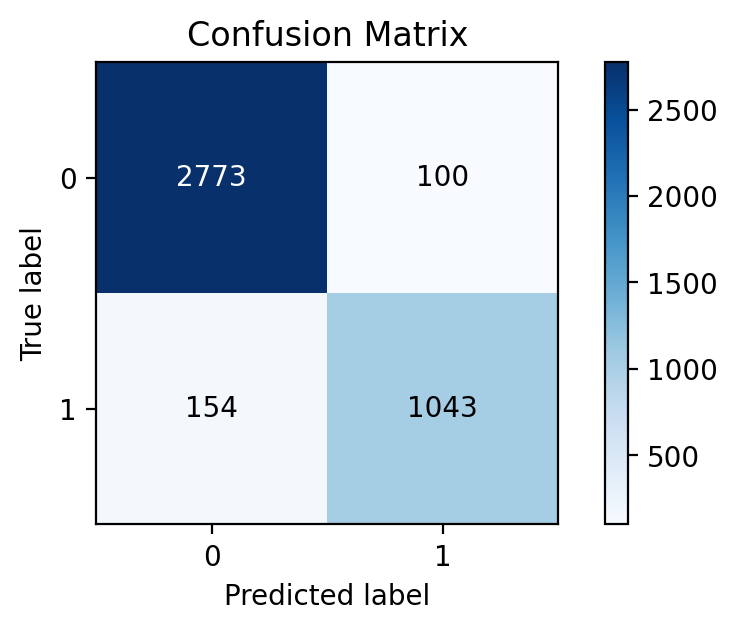

,ROC AUC,Precision,Recall,F1
Random Forest + FastText,0.971677,0.912511,0.871345,0.891453


In [87]:
gs_rf_pred = best_rf_ft.predict(X_test_ft)
gs_rf_probs = best_rf_ft.predict_proba(X_test_ft)[:, 1]

plt.show(splt.metrics.plot_confusion_matrix(y_test, gs_rf_pred))
clf_report('Random Forest + FastText', y_test, gs_rf_pred, gs_rf_probs)

__По сравнению с базовой моделью RF__: 

- показатель по целевой метрике ROC AUC увеличился на 0,6484%;
    
- уменьшилось количество ложноположительных и ложноотрицательных результатов.

In [ ]:
# joblib.dump(gs_rf.best_estimator_, 'best_rf_ft.pkl')

### SVC + Tfidf

In [ ]:
svc = SVC(probability=True)
svc.fit(X_train_scaled, y_train)

In [17]:
svc_params = {
    'C': [.01, .1, 1, 5, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': [.01, .1, 1, 5, 10, 100]
}

In [18]:
gs_svc = GridSearchCV(svc, svc_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gs_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 100],
                         'gamma': [0.01, 0.1, 1, 5, 10, 100],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             scoring='roc_auc', verbose=1)

In [19]:
gs_svc.best_score_, gs_svc.best_params_

(0.9683871340680051, {'C': 5, 'gamma': 1, 'kernel': 'rbf'})

In [88]:
best_svc_params = {'C': 5, 'gamma': 1, 'kernel': 'rbf'}

In [89]:
best_svc_tfidf = SVC(**best_svc_params, probability=True)
best_svc_tfidf.fit(X_train_scaled, y_train)

SVC(C=5, gamma=1, probability=True)

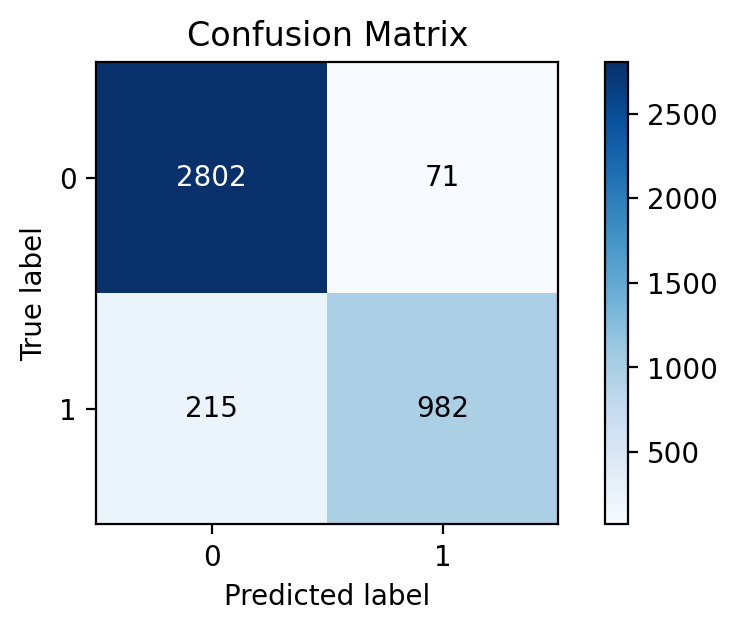

,ROC AUC,Precision,Recall,F1
SVC + Tfidf,0.969907,0.932574,0.820384,0.872889


In [90]:
gs_svc_pred = best_svc_tfidf.predict(X_test_scaled)
gs_svc_probs = best_svc_tfidf.predict_proba(X_test_scaled)[:, 1]

plt.show(splt.metrics.plot_confusion_matrix(y_test, gs_svc_pred))
clf_report('SVC + Tfidf', y_test, gs_svc_pred, gs_svc_probs)

__По сравнению с базовой моделью SVC__:

- ROC AUC скор снизился на 0,1937%;
    
- после подбора гиперпараметров у модели появился bias к преобладающему классу «не спам»;
    
- +1,3456% к Precision, -3,4317% от Recall.

### Gradient Boosting + FastText

In [ ]:
gb2 = GradientBoostingClassifier(random_state=8)
gb2.fit(X_train_ft, y_train)

In [28]:
gb_params = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [.001, .01, .1, .3]
}

In [30]:
gs_gb = GridSearchCV(gb2, gb_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
gs_gb.fit(X_train_ft, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=8),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [50, 100, 300, 500]},
             scoring='roc_auc', verbose=1)

In [31]:
gs_gb.best_score_, gs_gb.best_params_

(0.9814584789379789,
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500})

In [82]:
best_gb_params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

In [83]:
# best_gb_ft = GradientBoostingClassifier(**gs_gb.best_params_)
best_gb_ft = GradientBoostingClassifier(**best_gb_params)
best_gb_ft.fit(X_train_ft, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=500)

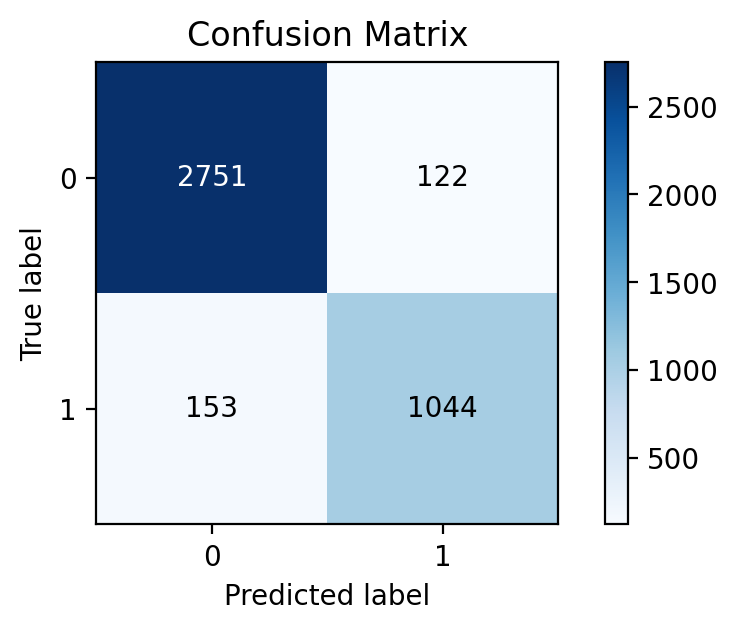

,ROC AUC,Precision,Recall,F1
Gradient Boosting + FastText,0.969413,0.895369,0.872180,0.883623


In [84]:
gs_gb_pred = best_gb_ft.predict(X_test_ft)
gs_gb_probs = best_gb_ft.predict_proba(X_test_ft)[:, 1]

plt.show(splt.metrics.plot_confusion_matrix(y_test, gs_gb_pred))
clf_report('Gradient Boosting + FastText', y_test, gs_gb_pred, gs_gb_probs)

__По сравнению с базавой моделью Gradient Boosting__:

- показатель по ROC AUC увеличился на 0,3081%;
    
- увеличислось количество верно классифицированных спамных писем, но только за счёт уменьшения ложноположительных срабатываний, тогда как количество ложноотрицательных предсказаний напротив увеличилось.

### Logistic Regression + FastText

In [45]:
lr2 = LogisticRegression()
lr2.fit(X_train_ft, y_train)

LogisticRegression()

In [68]:
lr_params = {
    'class_weight': [None, 'balanced'],
    'C': np.logspace(-3, 3, 8),
    'solver': ['newton-cg', 'sag', 'saga', 'liblinear'],
    'max_iter': [3, 5, 10, 30, 50, 100]
}

In [ ]:
gs_lr = GridSearchCV(lr2, lr_params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=1)
gs_lr.fit(X_train_ft, y_train)

In [70]:
gs_lr.best_score_, gs_lr.best_params_

(0.979091075866753,
 {'C': 1000.0,
  'class_weight': 'balanced',
  'max_iter': 10,
  'solver': 'liblinear'})

In [71]:
best_lr_params = {
  'C': 1000.0,
  'class_weight': 'balanced',
  'max_iter': 10,
  'solver': 'liblinear'
}

In [72]:
best_lr_ft = LogisticRegression(**best_lr_params)
best_lr_ft.fit(X_train_ft, y_train)

LogisticRegression(C=1000.0, class_weight='balanced', max_iter=10,
                   solver='liblinear')

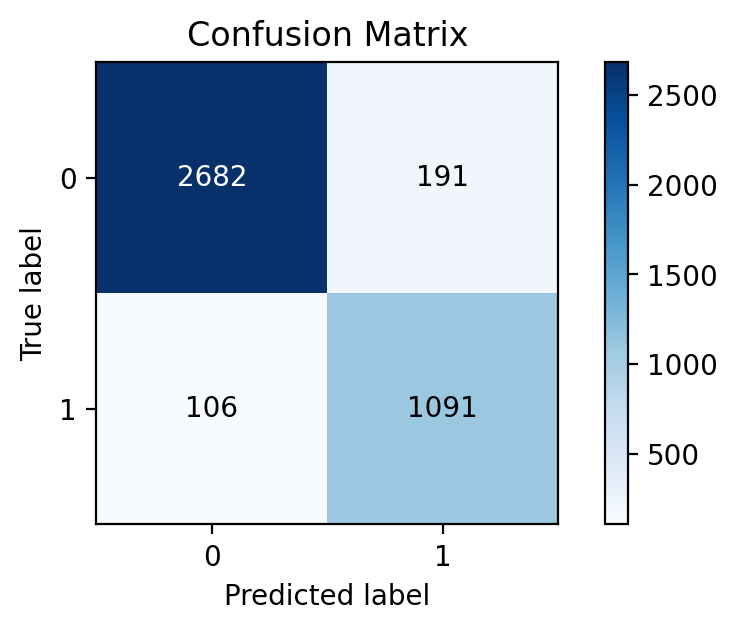

,ROC AUC,Precision,Recall,F1
Logistic Regression + FastText,0.968570,0.851014,0.911445,0.880194


In [73]:
gs_lr_pred = best_lr_ft.predict(X_test_ft)
gs_lr_probs = best_lr_ft.predict_proba(X_test_ft)[:, 1]

plt.show(splt.metrics.plot_confusion_matrix(y_test, gs_lr_pred))
clf_report('Logistic Regression + FastText', y_test, gs_lr_pred, gs_lr_probs)

__По сравнению с базовой моделью Logistic Regression__:

- отмечается самый большой прирост качества по показателю Recall (+4,3924%);
    
- после донастройки гиперпараметров модель определяет наибольшее (среди других моделей) количество спамных писем (recall == 91,1445%), но больше делает ошибок на классе нормальных писем.

## Предикт

Предсказание на тесте моделью RandomForest, обученной на эмбеддингах fasttext, после побора оптимальных гиперпараметров по сетке, так как у данной модели самы высокий скор по метрике ROC AUC.

In [96]:
test_data = pd.read_csv('/kaggle/input/enron-dataset/test_preproc.csv')
test_data['text__preproc'] = test_data['text__preproc'].fillna('emptytokensequence')

In [100]:
test = test_data['text__preproc']

test_ft = pd.DataFrame(
    data=test.apply(lambda x: ft_model.get_sentence_vector(x)).tolist(),
    columns=[f'v_{i+1}' for i in range(150)]
)

test_ftscaled = pd.DataFrame(sc2.transform(test_ft), columns=test_ft.columns.tolist())

In [117]:
predicted_probs = best_rf_ft.predict_proba(test_ft)[:, 1]

In [120]:
predict_df = pd.DataFrame({'score': predicted_probs, 'text': test_data['text']})
predict_df.to_csv('test-score.csv', index=False)